# Step 1: Install && Import library

In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.9 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.9 kB 262.6 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.9 kB 262.6 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/60.9 kB 260.9 kB/s eta 0:00:01
     -------------------------------------- 60.9/60.9 kB 294.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/16.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.6 MB 1.4 MB/s eta 0:00:13
   ---------------------------------------- 0.1/16.6 MB 1.2 MB/s eta 0:00:15
   ---------------------------------------- 0.2/16.6 MB 1.7 MB/s eta 0:00:10
   - -------------------------------------- 0.5/16.6 MB 3.2 MB/s eta 0:00:06
   -- ------------------------------------- 0.8/16.6 MB 4.4 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/16.6 MB 4.4 MB/s eta 0:00:04
   

In [2]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

# Step 2: Reading data
The data comes in .csv format and we need to upload it using pandas pd.read_csv() which stores the data as a pandas DataFrame.

In [10]:
data = pd.read_csv('data.csv')
print(data.head(25))
print(data.info())
print(data.describe())
print(data["diagnosis"].unique()) #Print unique values in the column: 'B' and 'M'

          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0     842302         M       17.990         10.38          122.80     1001.0   
1     842517         M       20.570         17.77          132.90     1326.0   
2   84300903         M       19.690         21.25          130.00     1203.0   
3   84348301         M       11.420         20.38           77.58      386.1   
4   84358402         M       20.290         14.34          135.10     1297.0   
5     843786         M       12.450         15.70           82.57      477.1   
6     844359         M       18.250         19.98          119.60     1040.0   
7   84458202         M       13.710         20.83           90.20      577.9   
8     844981         M       13.000         21.82           87.50      519.8   
9   84501001         M       12.460         24.04           83.97      475.9   
10    845636         M       16.020         23.24          102.70      797.8   
11  84610002         M       15.780     

List of ‘predictor names’ will be useful later in the code when we need to refer to specific predictor columns.

In [11]:
# Extract calssification target. Store the column diagnosis in a variable named 'target'
target = data.loc[:, "diagnosis"]
# Convert the target variable to a binary representation (0 or 1)
target = (target == "M").astype(int) # M ==> 1, B ==> 0
# Extract all other columns except 'diagnosis' as predictors. Data predictors also means features
data_predictors = data.loc[:, data.columns != 'diagnosis']
# Create a list of predictor names
predictor_names = data_predictors.columns

# Step 3: Splitting a dataset
The dataset is split into a training set and a testing set (test size: 30%)

In [12]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(data_predictors, target, test_size=0.3,random_state=0)

# Step 4: Function

## 4.1 Create an initial population (step 1)
Here we generate the population with the next parameters:
* population_size — represents the number of chromosomes (number of rows in population)
* num_features — number of columns from x_train or number of predictors
* min_features — minimal number of features that each chromosome has to have; if min_features = 2; every chromosome has at least two features included (at least two ones)
* max_features — the maximal number of features that each chromosome has to have

Example with next hyperparameters: population_size = 4; num_features = 5; min_features = 2, max_features = 4.

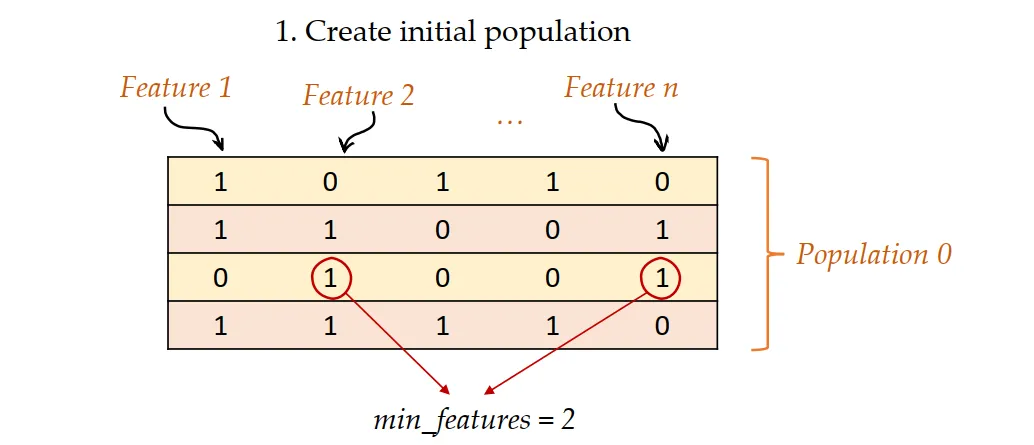

In [14]:
#Create random individuals for the genetic algorithm
#This function will receive 4 parameters.
def generate_random_individuals(population_size, num_features, min_features, max_features):
    # Create a matrix of zeros with dimensions (population_size X num_features)
    individuals = np.zeros((population_size, num_features))
    # For each individual in the population
    for i in range(population_size):
        # Generate a random number of ones between min_features and max_features
        num_ones = np.random.randint(min_features, max_features+1)
        # Generate a random set of indices to place the ones
        ones_indices = np.random.choice(num_features, num_ones, replace=False)
        # Place the ones in the corresponding indices
        individuals[i, ones_indices] = 1
    return individuals

# 4.2: Train a model on every chromosome from the population and calculate accuracy (step 2 & 3)
The function train_model takes in the following inputs:
* x_train, x_test, y_train, y_test and
* predictor_names.

In [15]:
# 2.& 3.: Train model and get precision
def train_model(x_train, x_test, y_train, y_test, predictor_names):
    x_train = x_train.loc[:, predictor_names]
    x_test = x_test.loc[:, predictor_names]
    
    #Building the random forest model 
    mdl = RandomForestClassifier(random_state=1) #Creating the Random Forest Classifier Model
    mdl.fit(x_train, y_train)                    #Training the Model with x_train & y_train
    y_hat = mdl.predict(x_test)                  #Predicting the x_test 
    prec = precision_score(y_test, y_hat)        #Precision: The best value is 1 and the worst value is 0.
    return prec

In [16]:
def choose_parents(population,accuracy,elite_percent):
    # Get elite of top 2 which doesn't mutate
    elite_num = int(round(((elite_percent*population.shape[0]) // 2) * 2))
    ind_ac = np.argsort(-accuracy)
    top_perc = ind_ac[:elite_num]
    elite_population = population[top_perc,:]   # We should keep this elite
    
    # Normalize accuracy to obtain weights for roulette wheel selection
    weight_norm = accuracy / accuracy.sum()     # calculate normalised weight from accuracy
    weight_comu = weight_norm.cumsum()          # calc cumulative weight from accuracy
   
    # Roulette wheel selection   
    num_parents_wo_elite = population.shape[0] - elite_num
    parents_wo_elite = np.empty([num_parents_wo_elite,population.shape[1]])
    for count in range(num_parents_wo_elite):
        b = weight_comu[-1]                         # current last element of weight_comu 
        rand_num = np.random.uniform(0,b)         # random foating-point number btw 0 and current max weight_comu
        
        indices = np.searchsorted(weight_comu,rand_num) # get indices of the number in weight_comu greater than rand_num
        parents_wo_elite[count,:] = population[indices, :]
        
    parents = np.concatenate((elite_population, parents_wo_elite), axis=0)  # Concatenate elite and parents_wo_elite to get all parents
    return parents

In [18]:
def one_point_crossover(parents,elite_percent,mutation_probability,min_features, max_features):
    elite_num = int(round(((elite_percent*population.shape[0]) // 2) * 2))
    crossover_population = np.zeros((parents.shape[0],parents.shape[1]))         # first two are elite
    crossover_population[0:elite_num,:] = parents[0:elite_num,:]
    
    for ii in range(int((parents.shape[0]-elite_num)/2)):
        n = 2*ii+elite_num                    # gives even number
        parents_couple = parents[n:n+2, :]    # comb of parents
        b2 = parents.shape[1]                 # num of features
        rand_n = np.random.randint(1, b2-1)   # generate rand number from 1 to num_of_features-1
        crossover_population[n,:] = np.concatenate([parents_couple[0, :rand_n], parents_couple[1, rand_n:]])
        crossover_population[n+1,:] = np.concatenate([parents_couple[1, :rand_n], parents_couple[0, rand_n:]])
        
    #check if every child has minimum number of features or all true values
    for kk in range(crossover_population.shape[0]):
        Sum = np.sum(crossover_population[kk,:])
        if Sum > max_features:
            # if the number of 1s is bigger than max number of features
            excess = int(Sum - max_features)
            indices = np.where(crossover_population[kk,:] == 1)[0]
            position1 = np.random.choice(indices, size=excess, replace=False)       
            crossover_population[kk, position1] = 0 # put 0s in random positions
        elif Sum < min_features:
            # if the number of 1s is smaller than min number of features
            missing = int(min_features - Sum)
            indices = np.where(crossover_population[kk,:] == 0)[0]
            position2 = np.random.choice(indices, size=missing, replace=False) 
            crossover_population[kk, position2] = 1 # put 1s in random positions

    # mutation
    child_row = crossover_population.shape[0]
    child_col = crossover_population.shape[1]
    num_mutations = round(child_row*child_col*mutation_probability)     
    for jj in range(num_mutations):
        ind_row = np.random.randint(0,child_row) # random number btw 0 and num of rows
        ind_col = np.random.randint(0,child_col) # random number btw 0 and num of colmns
        if (crossover_population[ind_row,ind_col] == 0 and 
            np.sum(crossover_population[ind_row,:]) < max_features):
            crossover_population[ind_row,ind_col] = 1
        elif (crossover_population[ind_row,ind_col] == 1 and 
              np.sum(crossover_population[ind_row,:]) >= min_features+1):
            crossover_population[ind_row,ind_col] = 0 
    
    return crossover_population 

In [19]:
# Hyperparameters
num_features = data_predictors.shape[1]
min_features = 2            # minimal number of features in a subset of features
population_size = 8         # size of population (number of instances)
max_iterations = 8          # maximum number of iterations
elite_percent = 0.4         # percentage of elite population which doesn't mutate
mutation_probability = 0.2  # percentage of total genes that mutate
max_features = 4            # maximum number of features in a subset of features

In [20]:
# Main loop - gen > 0
while gen < max_iterations-1:
    print('Begin iteration num {}/{}'.format(gen+2,max_iterations))
    gen += 1
    parents = choose_parents(population, accuracy, elite_percent)
    children = one_point_crossover(parents,elite_percent,mutation_probability,min_features,max_features)
    population = children
    for ind in range(population_size):
        predictor_names_ind = predictor_names[population[ind,:]==1]
        accuracy_ind = train_model(x_train,x_test,y_train,y_test,predictor_names_ind)
        accuracy[ind] = accuracy_ind
    best_acc_i[gen] = max(accuracy)
    
ind_max_acc = np.argmax(accuracy)
best_features = population[ind_max_acc,:]

NameError: name 'gen' is not defined